<a href="https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# Set the device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Dataset

In [3]:
df = pd.read_csv("spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
# Check class distribution
df['label'].value_counts(normalize = True)

,proportion
label,
0,0.865937
1,0.134063


# Split train dataset into train, validation and test sets

In [6]:
# Step 1: Split the original dataset into training set (70%) and temporary set (30%)
# Stratify ensures label distribution remains consistent across splits
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['text'], df['label'],
    test_size=0.3,
    random_state=2018,
    stratify=df['label']
)

# Step 2: Split the temporary set into validation set (15%) and test set (15%)
# Again, stratify to maintain label proportions
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels,
    test_size=0.5,
    random_state=2018,
    stratify=temp_labels
)

# Import BERT Model and BERT Tokenizer

In [7]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [9]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

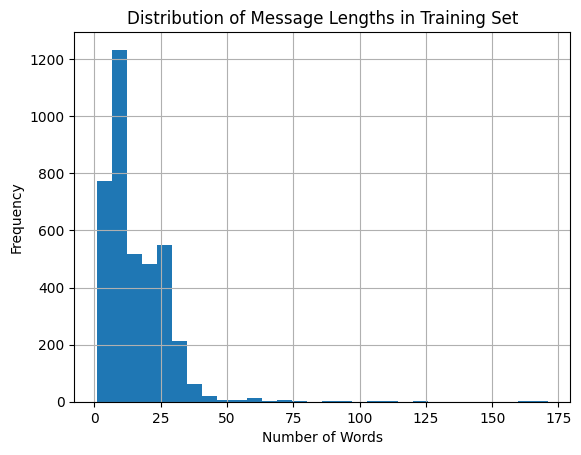

In [11]:
import matplotlib.pyplot as plt

# Get the number of words in each message in the training set
seq_len = [len(text.split()) for text in train_text]

# Plot a histogram of the sequence lengths
pd.Series(seq_len).hist(bins=30)
plt.title("Distribution of Message Lengths in Training Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [13]:
max_seq_len = 25

In [14]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [15]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [17]:
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [18]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [19]:
import torch
import torch.nn as nn

class BERT_Arch(nn.Module):
    def __init__(self, bert_model):
        super(BERT_Arch, self).__init__()

        # Load the pre-trained BERT model
        self.bert = bert_model

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(p=0.1)

        # Activation function
        self.relu = nn.ReLU()

        # First fully connected layer
        self.fc1 = nn.Linear(768, 512)

        # Output layer (for binary classification)
        self.fc2 = nn.Linear(512, 2)

        # LogSoftmax activation for output
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.
        Args:
            input_ids: Tensor of token ids from BERT tokenizer
            attention_mask: Tensor indicating padded indices
        Returns:
            Log probabilities for each class
        """

        # Get the CLS token representation from BERT
        _, cls_hidden_state = self.bert(input_ids, attention_mask=attention_mask, return_dict=False)

        # Pass through fully connected layers with ReLU and dropout
        x = self.fc1(cls_hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Apply softmax to get log-probabilities
        return self.softmax(x)


In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [21]:
# optimizer from hugging face transformers
from torch.optim import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [22]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
# Convert train_labels to a NumPy array to ensure correct input format
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels.to_numpy())

print(class_wts)

[0.57743559 3.72848948]


In [23]:
# convert class weights to tensor
weights = torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [24]:
def train(model, train_dataloader, optimizer, cross_entropy, device):
    """
    Train the BERT model for one epoch.

    Args:
        model: The BERT-based classification model.
        train_dataloader: Dataloader for the training data.
        optimizer: Optimizer used for training.
        cross_entropy: Loss function.
        device: Device to train the model on (CPU or GPU).

    Returns:
        avg_loss: Average training loss for the epoch.
        total_preds: Numpy array of model predictions.
    """

    model.train()  # Set model to training mode
    total_loss = 0
    total_preds = []

    # Iterate over batches
    for step, batch in enumerate(train_dataloader):

        # Print progress every 50 batches
        if step % 50 == 0 and step != 0:
            print(f'Batch {step:>5,} of {len(train_dataloader):>5,}.')

        # Move batch to the specified device
        batch = [item.to(device) for item in batch]
        input_ids, attention_mask, labels = batch

        # Clear previously accumulated gradients
        model.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Compute loss
        loss = cross_entropy(outputs, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model parameters
        optimizer.step()

        # Detach predictions and move to CPU
        preds = outputs.detach().cpu().numpy()
        total_preds.append(preds)

    # Compute average loss over all batches
    avg_loss = total_loss / len(train_dataloader)

    # Concatenate predictions into a single array
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [25]:
import time

def format_time(elapsed):
    """
    Format a time duration from seconds to a string in minutes and seconds.

    Args:
        elapsed (float): Time in seconds.

    Returns:
        str: Formatted time as 'Xm Ys'.
    """
    elapsed_rounded = int(round(elapsed))
    minutes = elapsed_rounded // 60
    seconds = elapsed_rounded % 60
    return f"{minutes}m {seconds}s"


In [26]:
def evaluate(model, val_dataloader, cross_entropy, device, format_time_func):
    """
    Evaluate the BERT model on the validation set.

    Args:
        model: The trained BERT-based classification model.
        val_dataloader: Dataloader for validation data.
        cross_entropy: Loss function.
        device: Device to run the model on (CPU or GPU).
        format_time_func: Function to format elapsed time.

    Returns:
        avg_loss: Average validation loss.
        total_preds: Numpy array of model predictions.
    """

    print("\nEvaluating...")
    t0 = time.time()  # Start time

    model.eval()  # Set model to evaluation mode (disable dropout)

    total_loss = 0
    total_preds = []

    # Iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Print progress every 50 batches
        if step % 50 == 0 and step != 0:
            elapsed = format_time_func(time.time() - t0)
            print(f'  Batch {step:>5,}  of  {len(val_dataloader):>5,}. Elapsed: {elapsed}')

        # Move batch to device
        batch = [item.to(device) for item in batch]
        input_ids, attention_mask, labels = batch

        # Disable gradient computation
        with torch.no_grad():
            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Compute loss
            loss = cross_entropy(outputs, labels)
            total_loss += loss.item()

            # Move predictions to CPU
            preds = outputs.detach().cpu().numpy()
            total_preds.append(preds)

    # Compute average loss
    avg_loss = total_loss / len(val_dataloader)

    # Combine predictions across batches
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


# Start Model Training

In [27]:
# Initialize the best validation loss to a large value
best_valid_loss = float('inf')

# Lists to store training and validation losses for each epoch
train_losses = []
valid_losses = []

# Loop through each epoch
for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1} / {epochs}')
    print('-' * 30)

    # Record start time
    t0 = time.time()

    # Train the model
    train_loss, _ = train(model, train_dataloader, optimizer, cross_entropy, device)

    # Evaluate the model
    valid_loss, _ = evaluate(model, val_dataloader, cross_entropy, device, format_time)

    # Save the model if validation loss has decreased
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
        print(">> Best model saved.")

    # Append losses to lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Print statistics for the epoch
    elapsed = format_time(time.time() - t0)
    print(f"Epoch completed in {elapsed}")
    print(f"Training Loss:   {train_loss:.3f}")
    print(f"Validation Loss: {valid_loss:.3f}")


Epoch 1 / 10
------------------------------
Batch    50 of   122.
Batch   100 of   122.

Evaluating...
>> Best model saved.
Epoch completed in 0m 15s
Training Loss:   0.519
Validation Loss: 0.313

Epoch 2 / 10
------------------------------
Batch    50 of   122.
Batch   100 of   122.

Evaluating...
>> Best model saved.
Epoch completed in 0m 9s
Training Loss:   0.335
Validation Loss: 0.255

Epoch 3 / 10
------------------------------
Batch    50 of   122.
Batch   100 of   122.

Evaluating...
>> Best model saved.
Epoch completed in 0m 8s
Training Loss:   0.270
Validation Loss: 0.194

Epoch 4 / 10
------------------------------
Batch    50 of   122.
Batch   100 of   122.

Evaluating...
Epoch completed in 0m 7s
Training Loss:   0.294
Validation Loss: 0.425

Epoch 5 / 10
------------------------------
Batch    50 of   122.
Batch   100 of   122.

Evaluating...
>> Best model saved.
Epoch completed in 0m 8s
Training Loss:   0.281
Validation Loss: 0.163

Epoch 6 / 10
--------------------------

# Load Saved Model

In [28]:
# Load the saved weights of the best model
model_path = 'saved_weights.pt'

# Load state_dict from the file and apply it to the model
model.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode after loading weights
model.eval()

print("Best model weights loaded successfully.")

Best model weights loaded successfully.


# Get Predictions for Test Data

In [29]:
# Generate predictions on the test data
with torch.no_grad():
    # Move inputs to the appropriate device (CPU or GPU)
    input_ids = test_seq.to(device)
    attention_mask = test_mask.to(device)

    # Forward pass through the model
    outputs = model(input_ids, attention_mask)

    # Move predictions to CPU and convert to NumPy array
    preds = outputs.detach().cpu().numpy()

print("Test predictions generated successfully.")

Test predictions generated successfully.


In [30]:
from sklearn.metrics import classification_report

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(preds, axis=1)

# Print classification metrics: precision, recall, f1-score, support
print("Model Performance on Test Set:\n")
print(classification_report(test_y, predicted_labels))

Model Performance on Test Set:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       724
           1       0.83      0.95      0.89       112

    accuracy                           0.97       836
   macro avg       0.91      0.96      0.93       836
weighted avg       0.97      0.97      0.97       836



In [31]:
# Generate confusion matrix
conf_matrix = pd.crosstab(test_y, predicted_labels, rownames=['Actual'], colnames=['Predicted'])

# Display the confusion matrix
print("Confusion Matrix:\n")
print(conf_matrix)

Confusion Matrix:

Predicted    0    1
Actual             
0          703   21
1            6  106
